In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, NVPFlow, LogNormal, GVAR, phase,\
Normal, floatX, MVNormal, MVNormalRW, Linear, LinearChol
import flows

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky
import math

np.random.seed(1234)
tf.set_random_seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
data = pd.read_csv('./data/test_aus_data.csv').values.astype(floatX).T[np.newaxis][:,1:]/100

In [3]:
data = data[:,1:] - data[:,:-1]

In [4]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.43681784 0.25903015 0.01298369]


In [5]:
np.any(np.isnan(data))

False

In [6]:
NUM_STEPS = data.shape[1]

with tf.variable_scope('walk_ord'):
    s1_prior_d = LogNormal(1, mu=math.log(0.01), sigma=3.)

    with tf.variable_scope('s1_inference', dtype=floatX):
        mu = tf.get_variable('mu', shape=[1], initializer=tf.constant_initializer(s1_prior_d.mu))
        logsigma = tf.get_variable('logsigma', shape=[1], 
                                   initializer=tf.constant_initializer(math.log(s1_prior_d.sigma) - 1.))
        sigma = tf.exp(logsigma)
        s1_d = LogNormal(1, mu=mu, sigma=sigma)
    
    s1 = s1_d.sample()
    tf.summary.scalar('s1_ord', s1[0])
    tf.add_to_collection('logdensities', s1_d.logdens(s1))
    
    s1_prior = s1_prior_d.logdens(s1)
    tf.add_to_collection('priors', s1_prior)
    
#distribution for shock increase factor
with tf.variable_scope('walk_shock'):
    incr_prior_d = LogNormal(1, mu=math.log(1.), sigma=2.)

    with tf.variable_scope('incr_inference', dtype=floatX):
        mu = tf.get_variable('mu', shape=[1], initializer=tf.constant_initializer(incr_prior_d.mu))
        logsigma = tf.get_variable('logsigma', shape=[1], 
                                   initializer=tf.constant_initializer(math.log(incr_prior_d.sigma) - 1.))
        sigma = tf.exp(logsigma)
        incr_d = LogNormal(1, mu=mu, sigma=sigma)

    incr = incr_d.sample()
    tf.add_to_collection('logdensities', incr_d.logdens(incr))
    
    incr_prior = incr_prior_d.logdens(incr)
    tf.add_to_collection('priors', incr_prior)

    incr += 1.3
    s_shock = s1*incr
    tf.summary.scalar('s1_shock', s_shock[0])
    
s0 = 80.
dim = [3,4]

K = dim[0] * dim[1]

PWalk = NormalRW(dim=None, sigma0=s0, sigma=s1, name='OrdWalk')
PWalk_shock = NormalRW(dim=None, sigma0=s0, sigma=s_shock, name='ShockWalk')

In [7]:
#model coefficients
gvar = GVAR(dim=dim[0]*dim[1], len=NUM_STEPS, name='coef_rw_inference')
outputs = gvar.sample()
# with tf.variable_scope('coefs_inference', dtype=floatX):
#     gvar = DFlow([LinearChol(NUM_STEPS*dim[0]*dim[1], name='coef_rw_inference', use_bias=False)], init_sigma=0.02)
#     outputs = tf.reshape(gvar.output, [1,NUM_STEPS, dim[0]*dim[1]])
#     outputs = tf.cumsum(outputs, axis=1)
#     mu = tf.get_variable('mu', [1,NUM_STEPS,dim[0]*dim[1]])
#     outputs += mu

tf.add_to_collection('logdensities', gvar.logdens)

In [8]:
outputs

<tf.Tensor 'coef_rw_inference_1/VAR/strided_slice_20:0' shape=(1, 20, 12) dtype=float64>

In [9]:
prior_ord = PWalk.logdens(outputs, reduce=False)
prior_shock = PWalk_shock.logdens(outputs, reduce=False)

In [10]:
prior_ord, prior_shock

(<tf.Tensor 'OrdWalk_2/concat:0' shape=(1, 20) dtype=float64>,
 <tf.Tensor 'ShockWalk_2/concat:0' shape=(1, 20) dtype=float64>)

In [11]:
with tf.variable_scope('Shock_Distr', reuse=tf.AUTO_REUSE):
    shock_init_d = Normal([1,8])
    shock_init = shock_init_d.sample()
    
    tf.add_to_collection('logdensities', shock_init_d.logdens(shock_init))
    
    shock_d = flows.dvae.RMultinomial([data.shape[1], 2], name='shock_distr')
    shocks_soft_uncond, shocks_soft_cond, (shocks_hard, shocks_hard_logp, encoding_entropy) =\
    shock_d.encode(shock_init)
    
    shocks_hard_logp = tf.reduce_sum(shocks_hard_logp)

In [12]:
shock_d.temp

<tf.Tensor 'Shock_Distr/shock_distr/controls/Exp:0' shape=(20, 1) dtype=float64>

In [13]:
shocks_hard

<tf.Tensor 'Shock_Distr/shock_distr_1/encoder/latent_inf/Cast_1:0' shape=(1, 20, 2) dtype=float64>

In [14]:
def create_hard_shock_prior(num_shocks):
    def c(n,k):
        from scipy.special import binom
        return tf.py_func(lambda x,y: int(binom(int(x),int(y))), [n, k], tf.int64)
    
    with tf.variable_scope('shocks_prior'):
        spd = tf.contrib.distributions.Poisson(rate=NUM_STEPS/5.)
        denum = tf.cast(c(NUM_STEPS, num_shocks), floatX)
        return tf.cast(spd.log_prob(tf.cast(num_shocks, tf.float32)), floatX) - tf.log(denum)

In [15]:
def create_soft_shock_prior(num_shocks):
#     return 0.
    lower = tf.cast(tf.floor(num_shocks), floatX)
    upper = lower + 1.
    lh = create_hard_shock_prior(lower)
    uh = create_hard_shock_prior(upper)
    prop = num_shocks-lower
    return lh*(1.-prop) + uh*prop

In [16]:
obs_d_prior = LogNormal(dim=None, mu=math.log(0.5), sigma=0.5)

with tf.variable_scope('obs_d_inference', dtype=floatX):
    mu = tf.get_variable('mu', shape=[1], initializer=tf.constant_initializer(math.log(0.5)))
    logsigma = tf.get_variable('logsigma', shape=[1], initializer=tf.constant_initializer(-5))
    sigma = tf.exp(logsigma)
    
    obs_d_post = LogNormal(1, mu=mu, sigma=sigma)
    obs_ds = obs_d_post.sample()
    
    obs_ds_logdens = obs_d_post.logdens(obs_ds)
    tf.add_to_collection('logdensities', obs_ds_logdens)
    tf.add_to_collection('priors', obs_d_prior.logdens(obs_ds))
    
    tf.summary.scalar('observ_sigma', obs_ds[0])

In [17]:
def create_param_walk_prior(shocks):
    with tf.name_scope('RW_prior'):
        tmp = tf.cast(shocks[:,:,1], floatX)
        print(tmp, prior_shock)
        prior = tmp*prior_shock + (1-tmp)*prior_ord
        print(prior)
        prior = tf.reduce_sum(prior) 
        return prior

In [18]:
def predict(observable_mask):
    out = tf.reshape(outputs, [NUM_STEPS, dim[0], dim[1]])
    
    def step(prev, x):
        mask = x[0]
        prev_pred = tf.where(mask, x[1], prev)[tf.newaxis]
        params = x[2]
        
        d = params[:,:-1]
        new_pred = tf.matmul(prev_pred, d)[0] + params[:,-1]
        return new_pred
    
    ar = tf.scan(step, [observable_mask, data[0], out], initializer=tf.zeros([dim[0]], dtype=floatX))
    return ar

In [19]:
data.shape[1]

20

In [20]:
stop_time = tf.placeholder_with_default(NUM_STEPS, ())
predict_mask = tf.range(0, data.shape[1], dtype=tf.int32) < stop_time
#используем в предсказаниях ровно stop_time последних наблюдений

In [21]:
preds = predict(predict_mask)

In [22]:
preds

<tf.Tensor 'scan/TensorArrayStack/TensorArrayGatherV3:0' shape=(20, 3) dtype=float64>

In [23]:
obs_d = Normal(dim=None, sigma=obs_ds, mu=0)

diffs = preds[:-1] - data[0,1:]

logl = obs_d.logdens(diffs, reduce=False)
logl *= tf.cast(predict_mask[:-1], floatX)[:,tf.newaxis]

logl = tf.reduce_sum(logl)
tf.add_to_collection('priors', logl)

In [24]:
tf.summary.scalar('logl', logl)

<tf.Tensor 'logl:0' shape=() dtype=string>

In [25]:
def create_kl(shocks, shocks_prior=0.):
    logdens = tf.reduce_sum(tf.get_collection('logdensities'))
    prior = tf.reduce_sum(tf.get_collection('priors'))
    
    param_walk_prior = create_param_walk_prior(shocks)
    KLd = -prior + logdens - shocks_prior - param_walk_prior
    KLd /= NUM_STEPS*dim[0]*dim[1]
    return KLd

In [26]:
tf.get_collection('logdensities')

[<tf.Tensor 'walk_ord/LogNormal_2/Sum:0' shape=() dtype=float64>,
 <tf.Tensor 'walk_shock/LogNormal_2/Sum:0' shape=() dtype=float64>,
 <tf.Tensor 'coef_rw_inference_1/VAR/logdens/add:0' shape=() dtype=float64>,
 <tf.Tensor 'Shock_Distr/Normal_2/Sum:0' shape=() dtype=float64>,
 <tf.Tensor 'obs_d_inference/LogNormal_2/Sum:0' shape=() dtype=float64>]

In [27]:
tf.get_collection('priors')

[<tf.Tensor 'walk_ord/LogNormal_3/Sum:0' shape=() dtype=float64>,
 <tf.Tensor 'walk_shock/LogNormal_3/Sum:0' shape=() dtype=float64>,
 <tf.Tensor 'obs_d_inference/LogNormal_3/Sum:0' shape=() dtype=float64>,
 <tf.Tensor 'Sum:0' shape=() dtype=float64>]

In [28]:
shocks_soft_cond

<tf.Tensor 'Shock_Distr/shock_distr_1/encoder/latent_inf/Reshape_4:0' shape=(1, 20, 2) dtype=float64>

In [29]:
num_shocks = tf.reduce_sum(shocks_soft_uncond[:,:,1:])
ssp = create_soft_shock_prior(num_shocks) #- encoding_entropy
soft_kl_uncond = create_kl(shocks_soft_uncond, shocks_prior=ssp)

num_shocks = tf.reduce_sum(shocks_soft_cond[:,:,1:])
ssp = create_soft_shock_prior(num_shocks) #- encoding_entropy
soft_kl_cond = create_kl(shocks_soft_cond, shocks_prior=ssp)

num_shocks = tf.reduce_sum(shocks_hard[:,:,1:])
hard_shocks_prior = create_hard_shock_prior(num_shocks) - shocks_hard_logp
hard_kl = create_kl(shocks_hard, shocks_prior=hard_shocks_prior)

Tensor("RW_prior/strided_slice:0", shape=(1, 20), dtype=float64) Tensor("ShockWalk_2/concat:0", shape=(1, 20), dtype=float64)
Tensor("RW_prior/add:0", shape=(1, 20), dtype=float64)
Tensor("RW_prior_1/strided_slice:0", shape=(1, 20), dtype=float64) Tensor("ShockWalk_2/concat:0", shape=(1, 20), dtype=float64)
Tensor("RW_prior_1/add:0", shape=(1, 20), dtype=float64)
Tensor("RW_prior_2/strided_slice:0", shape=(1, 20), dtype=float64) Tensor("ShockWalk_2/concat:0", shape=(1, 20), dtype=float64)
Tensor("RW_prior_2/add:0", shape=(1, 20), dtype=float64)


In [30]:
tf.summary.scalar('num_shocks', num_shocks)

<tf.Tensor 'num_shocks:0' shape=() dtype=string>

In [31]:
shocks_hard_logp

<tf.Tensor 'Shock_Distr/Sum:0' shape=() dtype=float64>

In [32]:
relax_cond = shock_d.build_relax(tf.reshape(shocks_soft_cond, [1,-1]))
relax_uncond = shock_d.build_relax(tf.reshape(shocks_soft_uncond, [1,-1]))

In [33]:
soft_kl_cond

<tf.Tensor 'truediv_1:0' shape=<unknown> dtype=float64>

In [34]:
eta = shock_d.eta

soft_control_cond = eta*soft_kl_cond + relax_cond
soft_control_uncond = eta*soft_kl_uncond - eta*soft_kl_cond - relax_cond + relax_uncond

stoped_grad = hard_kl - soft_control_cond# - nvil_baseline

target = shocks_hard_logp*stoped_grad + soft_control_uncond
target = tf.reduce_mean(target)

In [35]:
soft_control_uncond

<tf.Tensor 'add_8:0' shape=<unknown> dtype=float64>

In [36]:
shock_vars = shock_d.get_encoder_vars()

In [37]:
shock_vars_grad = tf.gradients(target, shock_vars, stop_gradients=stoped_grad)

In [38]:
controls = shock_d.get_control_vars()
cv_loss = shock_d.build_control_loss(shock_vars_grad)

tf.summary.scalar('cv_loss', cv_loss)

cv_gradients = tf.gradients(cv_loss, controls)

In [39]:
rest_vars = [x for x in tf.global_variables() if not (x in controls or x in shock_vars)]
rest_gradients = tf.gradients(hard_kl, rest_vars)

In [40]:
rest_vars

[<tf.Variable 'walk_ord/s1_inference/mu:0' shape=(1,) dtype=float64_ref>,
 <tf.Variable 'walk_ord/s1_inference/logsigma:0' shape=(1,) dtype=float64_ref>,
 <tf.Variable 'walk_shock/incr_inference/mu:0' shape=(1,) dtype=float64_ref>,
 <tf.Variable 'walk_shock/incr_inference/logsigma:0' shape=(1,) dtype=float64_ref>,
 <tf.Variable 'coef_rw_inference/lc_0/lowerd:0' shape=(78,) dtype=float64_ref>,
 <tf.Variable 'coef_rw_inference/lc_0/ldiag:0' shape=(12,) dtype=float64_ref>,
 <tf.Variable 'coef_rw_inference/lc_1/lowerd:0' shape=(78,) dtype=float64_ref>,
 <tf.Variable 'coef_rw_inference/lc_1/ldiag:0' shape=(12,) dtype=float64_ref>,
 <tf.Variable 'coef_rw_inference/lc_1/W:0' shape=(12, 12) dtype=float64_ref>,
 <tf.Variable 'coef_rw_inference/lc_2/lowerd:0' shape=(78,) dtype=float64_ref>,
 <tf.Variable 'coef_rw_inference/lc_2/ldiag:0' shape=(12,) dtype=float64_ref>,
 <tf.Variable 'coef_rw_inference/lc_2/W:0' shape=(12, 12) dtype=float64_ref>,
 <tf.Variable 'coef_rw_inference/lc_3/lowerd:0' sha

In [41]:
all_vars = shock_vars + rest_vars 
grads = shock_vars_grad + rest_gradients
main_updates = [(g,x) for x,g in zip(all_vars, grads)]
control_updates = [(g,x) for x,g in zip(controls, cv_gradients)]

In [42]:
tf.summary.scalar('KLd', hard_kl)

<tf.Tensor 'KLd:0' shape=() dtype=string>

In [43]:
lr = tf.Variable(0.0001)
main_opt = tf.train.AdamOptimizer(lr).apply_gradients(main_updates)
cont_opt = tf.train.AdamOptimizer(0.0003).apply_gradients(control_updates)

In [44]:
control_updates

[(<tf.Tensor 'gradients_1/Shock_Distr/shock_distr/controls/Exp_grad/mul:0' shape=(20, 1) dtype=float64>,
  <tf.Variable 'Shock_Distr/shock_distr/controls/pretemp:0' shape=(20, 1) dtype=float64_ref>),
 (<tf.Tensor 'gradients_1/Shock_Distr/shock_distr/controls/Exp_1_grad/mul:0' shape=() dtype=float64>,
  <tf.Variable 'Shock_Distr/shock_distr/controls/preeta:0' shape=() dtype=float64_ref>),
 (<tf.Tensor 'gradients_1/AddN_30:0' shape=(40, 128) dtype=float64>,
  <tf.Variable 'Shock_Distr/shock_distr/controls/RELAX/FCN/d0/W:0' shape=(40, 128) dtype=float64_ref>),
 (<tf.Tensor 'gradients_1/AddN_29:0' shape=(1, 128) dtype=float64>,
  <tf.Variable 'Shock_Distr/shock_distr/controls/RELAX/FCN/d0/b:0' shape=(1, 128) dtype=float64_ref>),
 (<tf.Tensor 'gradients_1/AddN_24:0' shape=(128, 64) dtype=float64>,
  <tf.Variable 'Shock_Distr/shock_distr/controls/RELAX/FCN/d1/W:0' shape=(128, 64) dtype=float64_ref>),
 (<tf.Tensor 'gradients_1/AddN_22:0' shape=(1, 64) dtype=float64>,
  <tf.Variable 'Shock_Dis

In [45]:
opt = [main_opt, cont_opt]

In [46]:
sess = tf.InteractiveSession()

In [47]:
# !rm -R /tmp/tfdbg

In [48]:
!mkdir /tmp/tfdbg
writer = tf.summary.FileWriter('/tmp/tfdbg/proper_prior_var_rus_rate5')

mkdir: cannot create directory ‘/tmp/tfdbg’: File exists


In [49]:
writer.add_graph(tf.get_default_graph())

In [50]:
tf.global_variables_initializer().run()

In [51]:
hard_kl.eval()

1.4826616862363935

In [52]:
cv_gradients[0]

<tf.Tensor 'gradients_1/Shock_Distr/shock_distr/controls/Exp_grad/mul:0' shape=(20, 1) dtype=float64>

In [53]:
# a = []
# for _ in range(1000):
#     a.append(sess.run(cv_gradients[0]))
# np.mean(a, axis=0)

In [54]:
np.set_printoptions(precision=3)

In [55]:
# PWalk.inverse_sigma.eval()[:3,:3]

In [56]:
out = tf.reshape(outputs, [NUM_STEPS, dim[0], dim[1]])

In [57]:
epoch = 0

In [58]:
all_sum = tf.summary.merge_all()

In [59]:
def check_ppc(timestep):
    n = 1000
    all_preds = []
    for _ in range(n):
        tp = preds.eval({stop_time:timestep-1})
        tp = tp[timestep-1]
        all_preds.append(tp)
    all_preds = np.array(all_preds).mean(axis=0)
#     print(xs.shape)
    return np.sqrt(np.mean((all_preds - xs[0,timestep])**2))

In [60]:
# shock_d.logits.eval()

In [74]:
%%time
for epoch in range(epoch, epoch+2000):
    for i in range(1000):
        l, _ = sess.run([hard_kl, opt], {phase:True})
        if i % 30 == 0:
            s = all_sum.eval({phase:True})
            writer.add_summary(s, global_step=epoch*1000 + i)
    print(l)

0.49864360372006283
0.48699513269445377
0.48691725565017546
0.4798673087760238
0.5116578162874476
0.497947842735339
0.5071439541876965
0.49949462553892043
0.4973035459889009
0.5047347290325306
0.5043938058508559
0.5143573513899519
0.48307976718990914
0.5011605537787086
0.500836212770811
0.4961057770470087
0.5054427637279403
0.5119770859429006
0.4994586034872988
0.5356019286409761
0.5172805770177277
0.5037876270795139
0.4904597398338131
0.4879020493398544
0.507563505677146
0.5009605981639849
0.4912599626210112
0.4845515841433553
0.4913508292589872
0.49522819012963737
0.5138675121830543
0.4606450256519331
0.4936171000752888
0.4951396788331614
0.49611079194537905
0.5043524362764794
0.5061495849987442
0.5048439606622971
0.4869371785725202
0.47596875402914807
0.5073555626804221
0.507405041870599
0.4758979778493952
0.5154226508938635
0.4766894256448045
0.497176165176387
0.48696472268906066
0.48277567469778737
0.48673879709734513
0.507666259158345
0.4877510086683389
0.5030586508934931
0.48848

0.48195605510128703
0.4765374374184328
0.4928669745582724
0.47611347713980834
0.5076881850920709
0.48821632512626156
0.5030800000451795
0.5042729857653555
0.5044594681934138
0.4933177998275518
0.49397911208102985
0.5043514156968688
0.49031984387632643
0.5272428476602881
0.4956777070745877
0.5065303873124278
0.4975993038451532
0.5081268393516986
0.4868501737634645
0.512632647054711
0.5024243181401176
0.5008885776959161
0.4856099471175412
0.5047524377997228
0.49253083796111524
0.5111094478382625
0.5168544817192811
0.4994592493089913
0.5081318404237957
0.5046651747875088
0.5010008913958849
0.49592168122566327
0.47607496024453394
0.5008365088525882
0.5078144062147439
0.5238853911257465
0.5193544422665506
0.452504134813248
0.5199162337017124
0.49730743749544953
0.5054765624382728
0.5006887596246604
0.4775498170051016
0.5042070514949785
0.4968415977450858
0.5097261793011566
0.4993488417579873
0.46930468179632806
0.4855345944196609
0.5052846319488343
0.5049438337412437
0.4676723341318128
0.51

0.490349815284204
0.5082958858897709
0.4778147427589156
0.4940621710337017
0.49473727281954183
0.4843654007233738
0.49894458886619425
0.4899369566258673
0.4657525761205953
0.5109391773840202
0.49961923653848167
0.5177321842159702
0.4964413579062954
0.5161919840164461
0.5181155204083507
0.4738782983107574
0.49929092132433606
0.5048274394263944
0.49876623714154417
0.5046019011615852
0.480997795775207
0.4985079675118134
0.5216487183613014
0.49721635577608225
0.48250953327451546
0.5484945238200687
0.48517389208202294
0.48731196890261663
0.4960318840476958
0.4832595928064388
0.48715927530179215
0.49691670085215495
0.5038180134686466
0.5119214229255173
0.4932876448742116
0.4869449678713451
0.49562910452465353
0.5105401962731582
0.5020150325266054
0.5033265308077605
0.5002042871369918
0.481744642640165
0.48485924600746366
0.47894744369878545
0.5004878232345668
0.5017827953456028
0.5026260692760459
0.5263615073773363
0.494275073427184
0.49348601229286354
0.4882256600048668
0.5034231661130225
0

0.4922087349448726
0.48926824687917
0.4962105693785129
0.5044451813684536
0.5004957311959001
0.5012201102001543
0.5057924929652267
0.5002719652136146
0.5070998064691428
0.5001070139129558
0.516925264406301
0.4968278177545135
0.5153521786011594
0.4889018272218839
0.4943265719992231
0.5015081878443456
0.47125486282639123
0.4915650086960878
0.5050268135103626
0.4911044770890458
0.4976179869840427
0.4803343852399332
0.5065036754554862
0.5088585386112963
0.5066470443832325
0.5087887448247069
0.5237314581746664
0.5117454273320116
0.4930833896260128
0.4909678378921612
0.5056601551970327
0.49463088905222796
0.48549173065893714
0.4742862979744297
0.50815503160818
0.48415969438334516
0.4897016853472851
0.49440387996590285
0.5020264904350508
0.5105563129298005
0.4786237437602755
0.5032229941314348
0.497673792987608
0.4858713011156688
0.4883228172200191
0.5000133929912309
0.48441579867134504
0.49652120790394655
0.49553282913533486
0.49956852639197796
0.5069387656834025
0.4972431303480505
0.5066841

0.49459876987700613
0.5025375189994047
0.5064772462079915
0.4817769450565175
0.4890707103055926
0.5078242536339145
0.47973274885439776
0.48333576091610836
0.4954256306795969
0.5174047399687837
0.4860241561695991
0.5019447925543877
0.4972694286385812
0.4856621616895756
0.489654502668237
0.49036326277157843
0.5034401467950815
0.4996578888831493
0.4942198624280091
0.4808466592811911
0.49964673047589325
0.48895670107605205
0.4973798534079947
0.48278866309120594
0.48972865642701985
0.5023014860441279
0.4943578114078164
0.500583147743834
0.4903288601269466
0.4980510864553646
0.4956239977853443
0.49365189427290707
0.5092710307375284
0.4949800608688025
0.5150891283104627
0.4696611470279071
0.5023381909520099
0.4861950711694126
0.5393040231833647
0.4782061016397771
0.4854450549635487
0.4796098563740981
0.493188251225438
0.5158412591218136
0.4990869633205669
0.5129029717369737
0.4872170324632345
0.478190775048409
0.4953374067409004
0.4920044669815032
0.5042020509149278
0.5096010717123768
0.49400

In [73]:
lr.assign(0.00003).eval()

3e-05

In [75]:
ss = []
for _ in range(40000):
    s = shocks_hard.eval()[:,:,1].astype('float')
    ss.append(s)
ss = np.array(ss)
print(ss.mean(axis=0))

[[0.169 0.065 0.055 0.064 0.071 0.055 0.06  0.061 0.062 0.065 0.063 0.058
  0.063 0.064 0.056 0.063 0.068 0.062 0.055 0.054]]


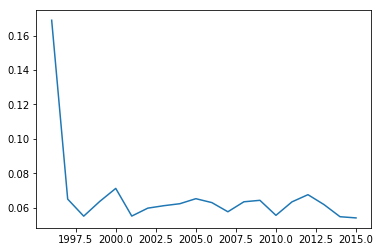

In [76]:
x = range(2016-data.shape[1],2016)
plt.plot(x, ss.mean(axis=0)[0][:])
plt.show()

In [ ]:
ss = []
aa = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
    aa.append(a)
ss = np.array(ss)
aa = np.array(aa)

In [ ]:
aa.mean(axis=0)[:5,:5]

In [ ]:
np.mean(ss, axis=0), np.std(ss, axis=0)

In [ ]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [ ]:
samples = []
for _ in range(3000):
    s = out.eval({phase:True})
    samples.append(s)
samples = np.array(samples)

In [ ]:
t = 10
sns.kdeplot(samples[:,t,2,0], samples[:,t,0,3])
plt.show()

In [ ]:
t = 10
# params[t]

In [ ]:
np.mean(samples[:,t], axis=0)

In [ ]:
np.std(samples[:,t], axis=0)

In [ ]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [ ]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [ ]:
score(s1,s2)

In [ ]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

## KDE + KL

In [ ]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

In [ ]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()